In [33]:
pip install spacy

In [34]:
import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [35]:
df.category.value_counts()

,count
category,
BUSINESS,4254
SPORTS,4167
CRIME,2893
SCIENCE,1381


In [36]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2025)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2025)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2025)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2025)

In [37]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

,count
category,
BUSINESS,1381
SPORTS,1381
CRIME,1381
SCIENCE,1381


In [38]:
df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1,
    'CRIME': 2,
    'SCIENCE': 3
})
df_balanced.head()

,text,category,category_num
9085,Different Is the New Normal: Perspectives From...,BUSINESS,0
5758,3 Reasons Obama's Oil Tax Would Be Good For Am...,BUSINESS,0
1607,Seattle Passes Controversial New Tax On City's...,BUSINESS,0
9560,Ailes' Downfall Is A Testament To The Rising P...,BUSINESS,0
12140,Is Under Armour Copying Nike's Playbook? While...,BUSINESS,0


In [39]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [40]:
df_balanced['preprocessed_text'] = df_balanced['text'].apply(preprocess)
df_balanced.head(5)

,text,category,category_num,preprocessed_text
9085,Different Is the New Normal: Perspectives From...,BUSINESS,0,Different New Normal perspective China Travel ...
5758,3 Reasons Obama's Oil Tax Would Be Good For Am...,BUSINESS,0,3 Reasons Obama Oil Tax good America push gas ...
1607,Seattle Passes Controversial New Tax On City's...,BUSINESS,0,Seattle pass Controversial New Tax City big co...
9560,Ailes' Downfall Is A Testament To The Rising P...,BUSINESS,0,Ailes downfall testament rise power Women mess
12140,Is Under Armour Copying Nike's Playbook? While...,BUSINESS,0,Armour Copying Nike Playbook sport shoe appare...


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['preprocessed_text'],df_balanced['category_num'],test_size=0.2, random_state=2025)

In [42]:
X_train.shape

(4419,)

In [43]:
X_test.shape

(1105,)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer(ngram_range=(1,3))
X_train_vector = v.fit_transform(X_train)
X_test_vector = v.transform(X_test)
v.vocabulary_

{'listen': 58865,
 'extended': 35055,
 'audio': 8042,
 'clippers': 19464,
 'owner': 72284,
 'alleged': 4508,
 'racist': 80788,
 'rant': 81170,
 'listen extended': 58870,
 'extended audio': 35056,
 'audio clippers': 8045,
 'clippers owner': 19473,
 'owner alleged': 72285,
 'alleged racist': 4542,
 'racist rant': 80802,
 'listen extended audio': 58871,
 'extended audio clippers': 35057,
 'audio clippers owner': 8046,
 'clippers owner alleged': 19474,
 'owner alleged racist': 72286,
 'alleged racist rant': 4544,
 'national': 67095,
 'science': 88008,
 'olympiad': 70926,
 'ucf': 106077,
 'orlando': 71824,
 'national science': 67155,
 'science olympiad': 88106,
 'olympiad ucf': 70927,
 'ucf orlando': 106080,
 'national science olympiad': 67156,
 'science olympiad ucf': 88107,
 'olympiad ucf orlando': 70928,
 'sense': 89656,
 'meaning': 62993,
 'sense meaning': 89672,
 'nypd': 69723,
 'arrest': 6659,
 'second': 88918,
 'week': 110710,
 'nypd arrest': 69724,
 'arrest second': 6784,
 'second w

In [45]:
X_train_vector.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_vector,y_train)
model.score(X_test_vector, y_test)

0.8850678733031674

In [47]:
y_pred = model.predict(X_test_vector)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       275
           1       0.92      0.87      0.90       279
           2       0.86      0.96      0.91       272
           3       0.92      0.84      0.88       279

    accuracy                           0.89      1105
   macro avg       0.89      0.89      0.88      1105
weighted avg       0.89      0.89      0.88      1105



In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[241   7  14  13]
 [ 11 243  20   5]
 [  9   1 260   2]
 [ 24  13   8 234]]


Text(95.72222222222221, 0.5, 'Truth')

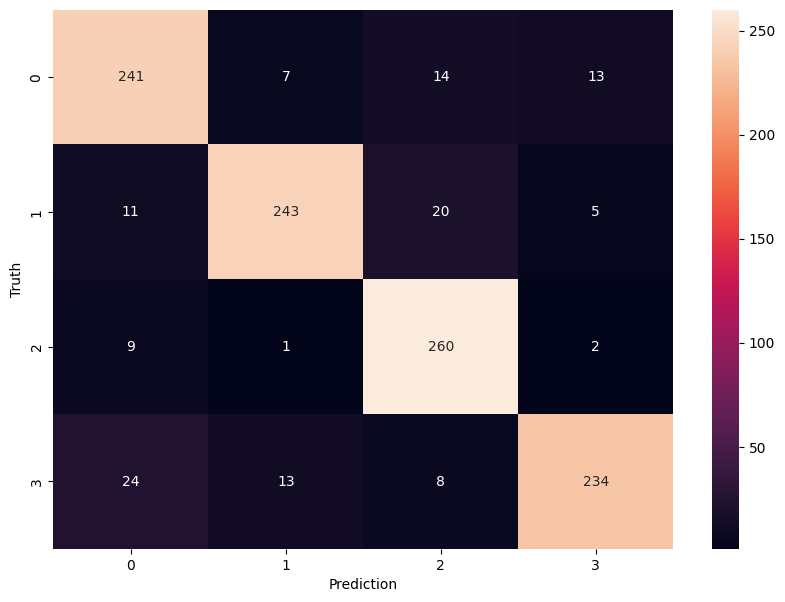

In [52]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')